In [16]:
import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time
import pickle
import pyLDAvis
import matplotlib.pyplot as plt

In [2]:
# load data
doc_year = [167,196,156,207,249,404,378,
271,
201,
768,
673,
823,
431,
681,
498,
597,
464,
657]

doc_ids =[0]+list(np.cumsum(doc_year))


alldata_new = pickle.load(open('output/20topics_newpreprocess_dict.p', 'rb'))
term_topic = alldata_new['term_topic']# term_topic is n_years*n_topics*n_terms
term_frequency = alldata_new['term_frequency']#term_frequency is n_years*n_terms
terms = alldata_new['terms']#terms is n_terms

doc_topic = []
doc_length=[]
for year in range(len(term_topic)):    
    doc_topic.append(alldata_new['doc_topic'][doc_ids[year]:doc_ids[year+1]])# doc_topic is n_docs*n_topics
    doc_length.append(alldata_new['doc_length'][doc_ids[year]:doc_ids[year+1]]) #doc_length is n_docs

In [3]:
# pyLDAvis.display(vis_dtm)


In [4]:
# visualize, each year
allvisdtm = []
for year in range(len(term_topic)):
    # doc related haven't processed.
    vis_dtm = pyLDAvis.prepare(topic_term_dists=term_topic[year], doc_topic_dists=doc_topic[year], doc_lengths=doc_length[year], vocab=terms, term_frequency=term_frequency[year],sort_topics=False)
    if vis_dtm[0]['x'].iloc[0]<0: # always put the first topic to be x>0 ,y>0
        vis_dtm[0]['x'] = -vis_dtm[0]['x']
    if vis_dtm[0]['y'].iloc[0]<0:
        vis_dtm[0]['y'] = -vis_dtm[0]['y']
    allvisdtm.append(vis_dtm)    
    with open("output/visdtm"+str(year+1)+".html", "w") as f:
        pyLDAvis.save_html(vis_dtm, f)
with open('output/all_visdtm.p','bw') as f:
    pickle.dump(allvisdtm,f)

/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-in

In [42]:
# rename topics by their top freq word
topics = range(term_topic.shape[1])

def topic_label(topic, term_topic, terms):
    term_freqs = np.sum(term_topic[:,topic,:], axis = 0)
    max_term = np.argsort(-term_freqs)[0]
    return(terms[max_term])


topic_labels = [topic_label(topic, term_topic, terms) for topic in topics]
import pandas as pd

with open('output/all_visdtm.p','br') as f:
    allvisdtm=pickle.load(f)
for visdtm in allvisdtm:

    visdtm[0]['topiclabel']=topic_labels
topic_labels

['spatial',
 'face',
 'speaker',
 'action',
 'trial',
 'relational',
 'reasoning',
 'probability',
 'stimulus',
 'concept',
 'speech',
 'child',
 'category',
 'rule',
 'sentence',
 'movement',
 'causal',
 'network',
 'student',
 'decision']

In [45]:
vis_dtm[0]

,Freq,cluster,topics,x,y,topiclbael,topiclabel
topic,,,,,,,
0,2.978116,1,1,0.026672,0.046131,spatial,spatial
1,2.943378,1,2,0.085313,-0.068752,face,face
2,4.099875,1,3,0.147104,0.124828,speaker,speaker
3,6.354779,1,4,-0.096817,0.038002,action,action
4,6.832277,1,5,0.049092,-0.085011,trial,trial
5,5.446514,1,6,-0.042770,-0.000276,relational,relational
6,4.488729,1,7,-0.104642,0.097955,reasoning,reasoning
7,4.054077,1,8,-0.073250,-0.063312,probability,probability
8,2.797365,1,9,0.124806,-0.125354,stimulus,stimulus


In [57]:
import seaborn as sns
g=sns.lmplot("x", "y", data=vis_dtm[0],hue="topiclabel",legend=True, fit_reg=False,size=100)
# add annotation for each point
g.map(plt.scatter, s=np.linspace(20,200,20))

plt.show()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

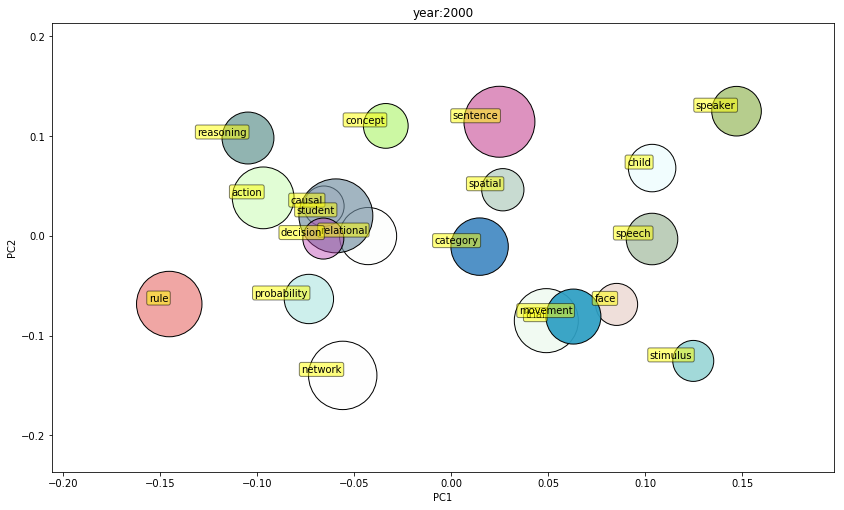

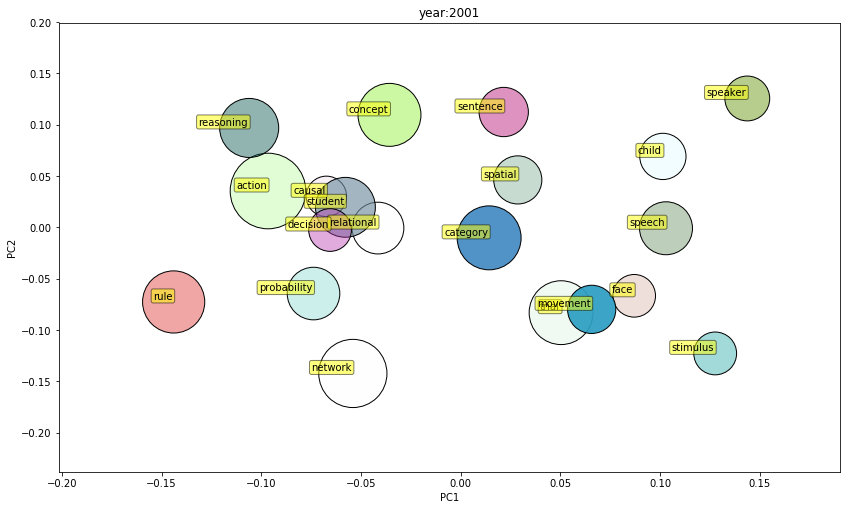

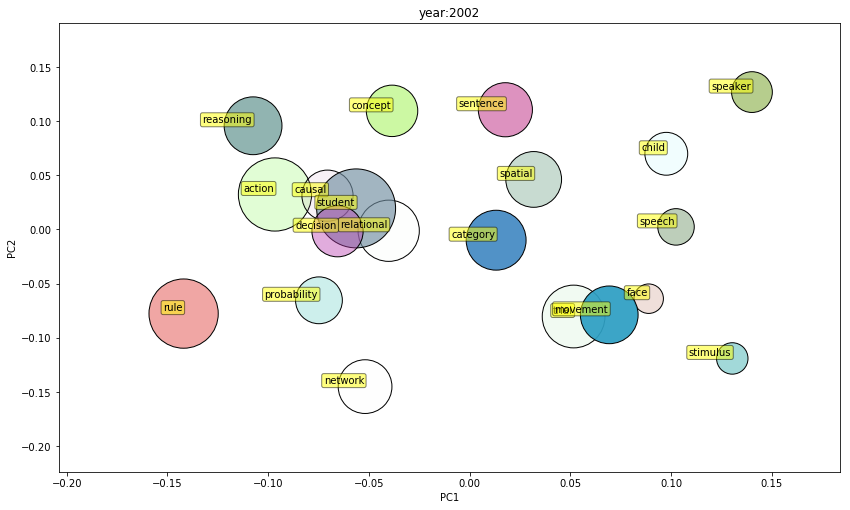

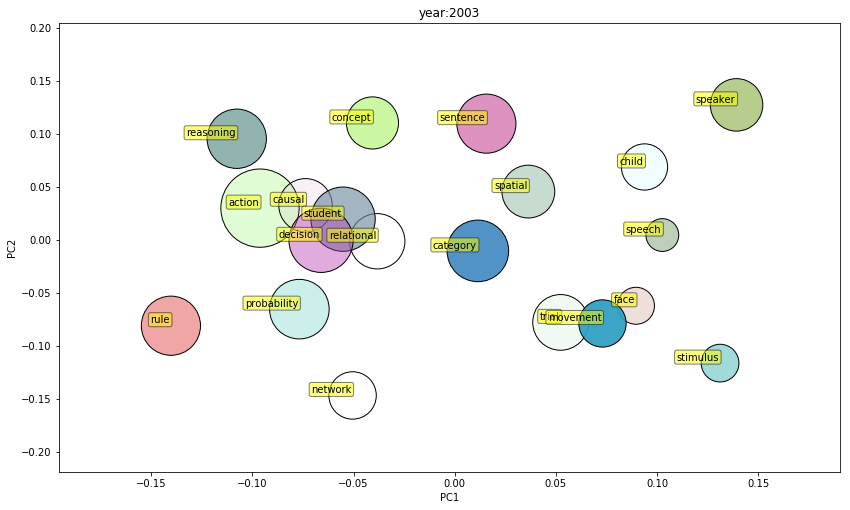

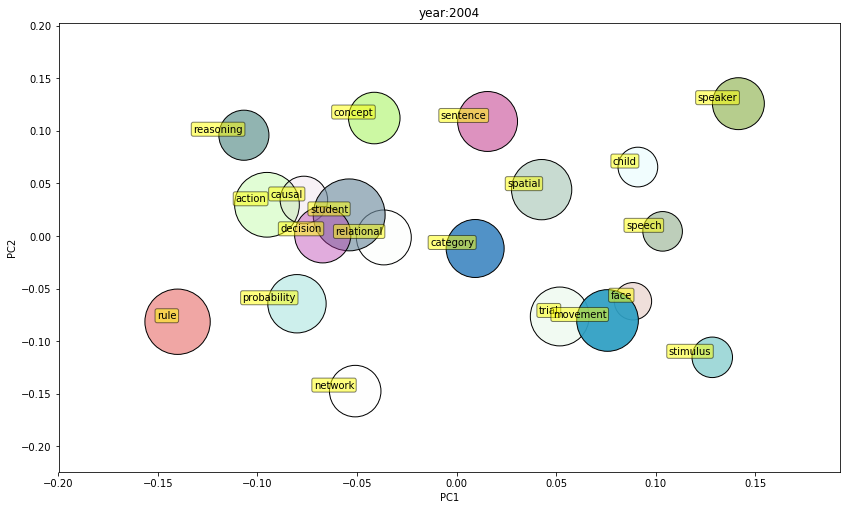

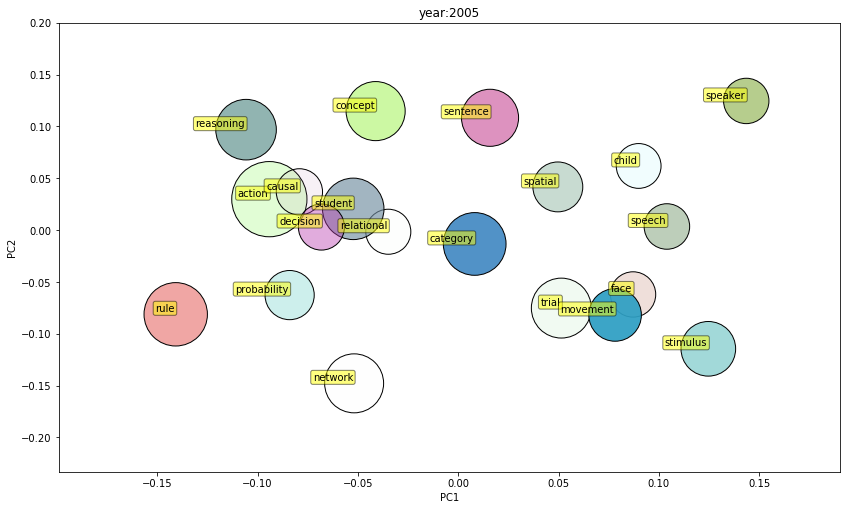

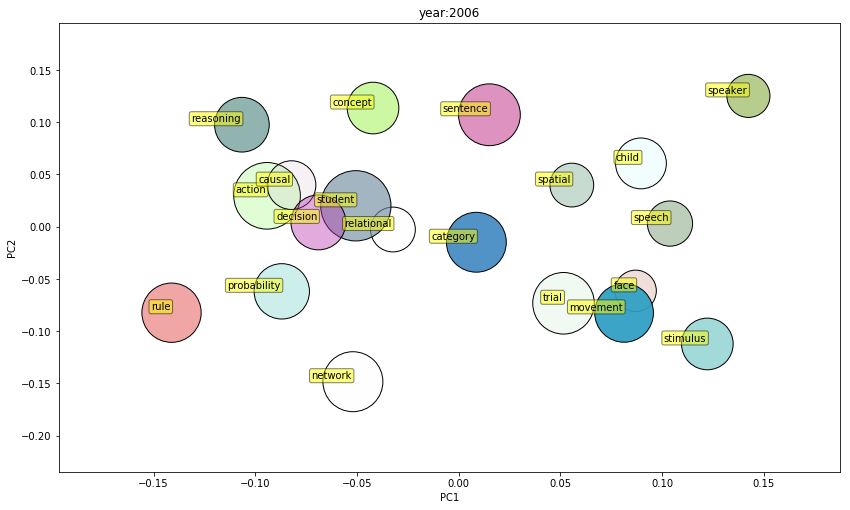

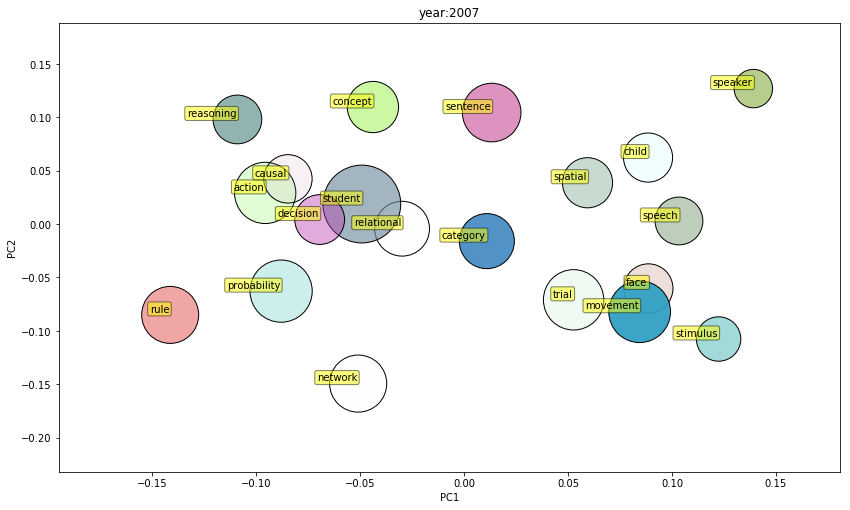

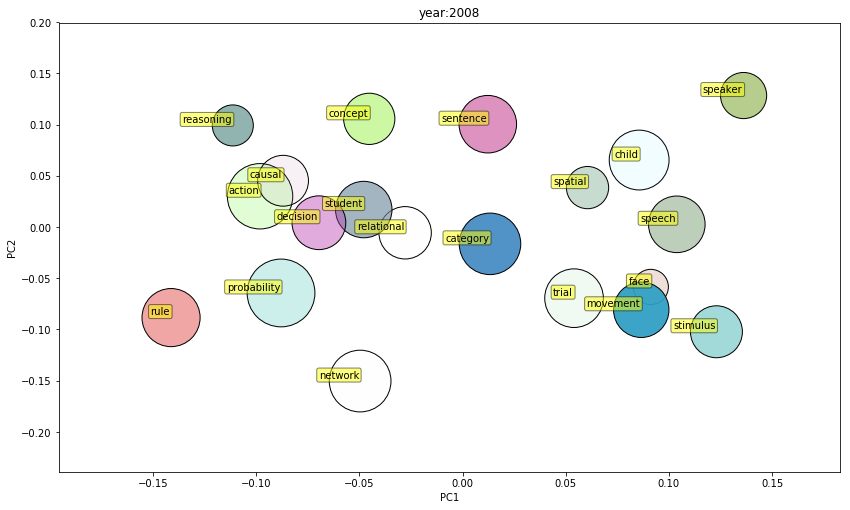

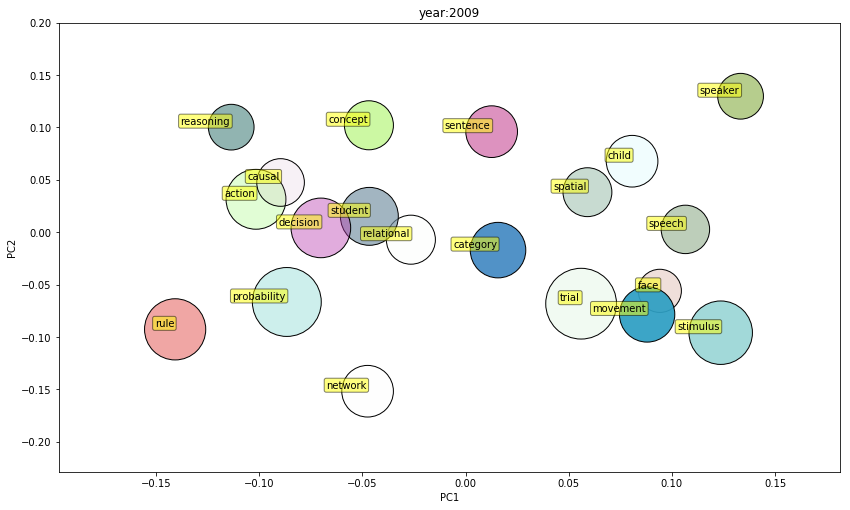

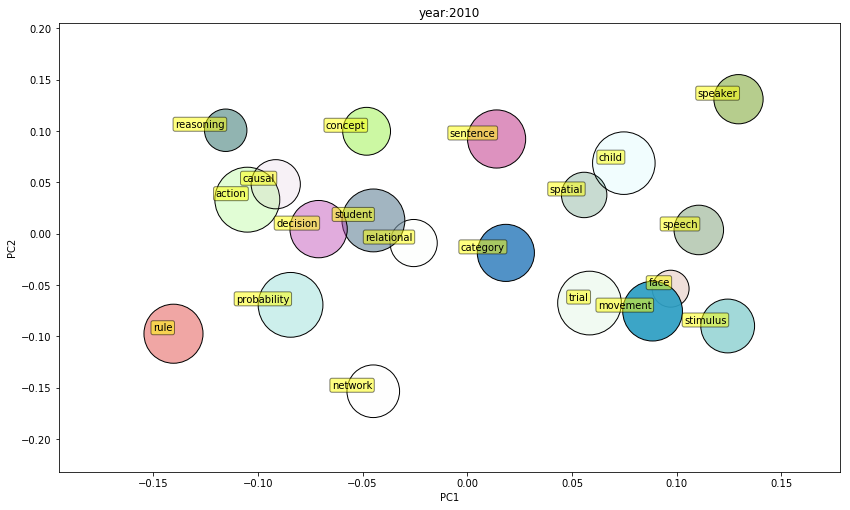

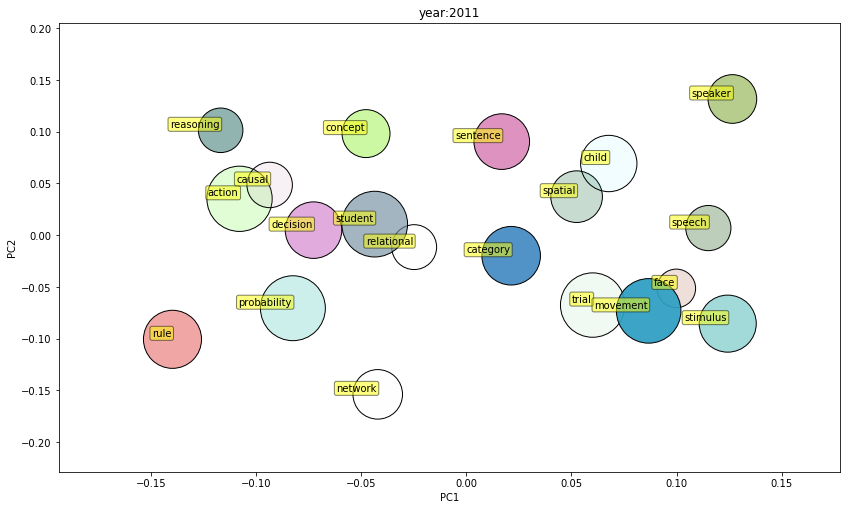

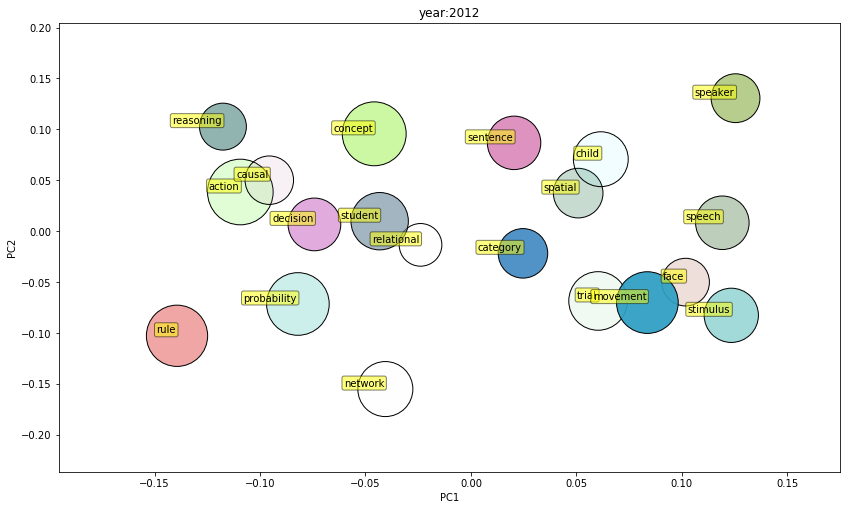

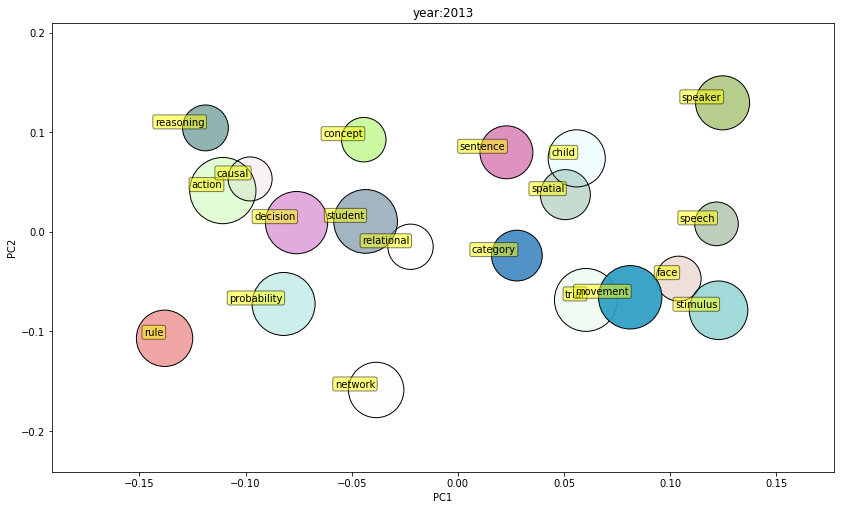

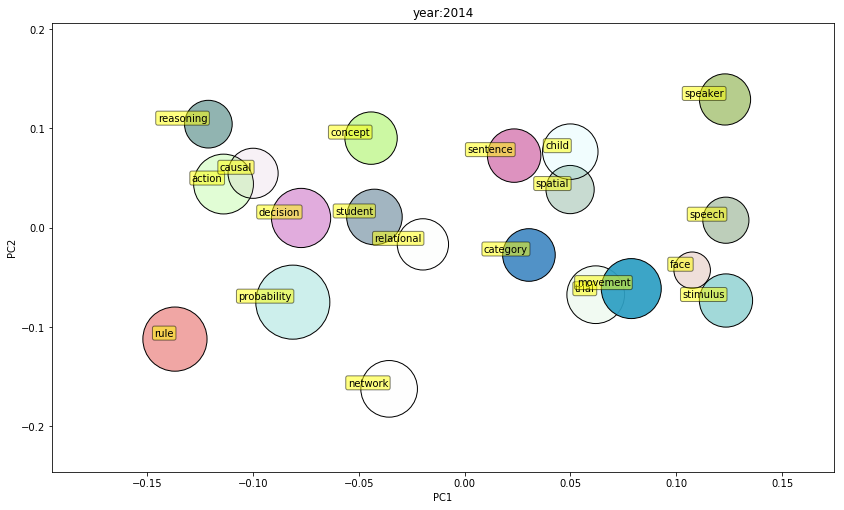

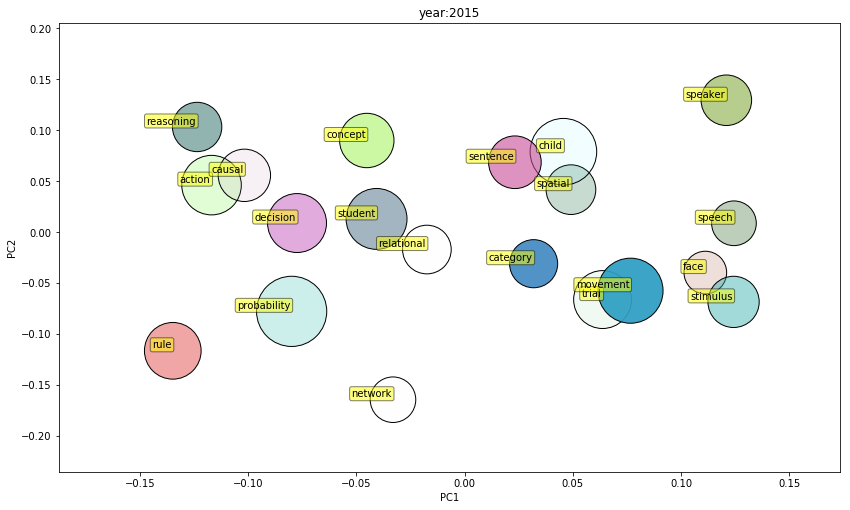

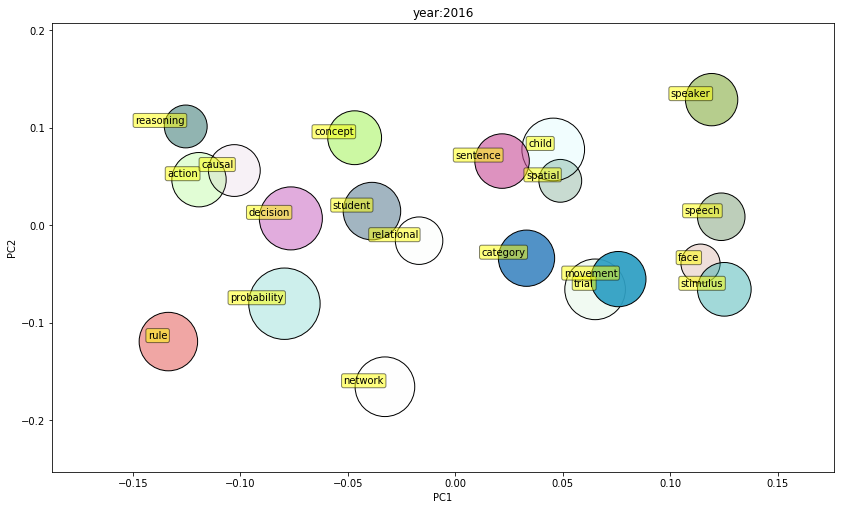

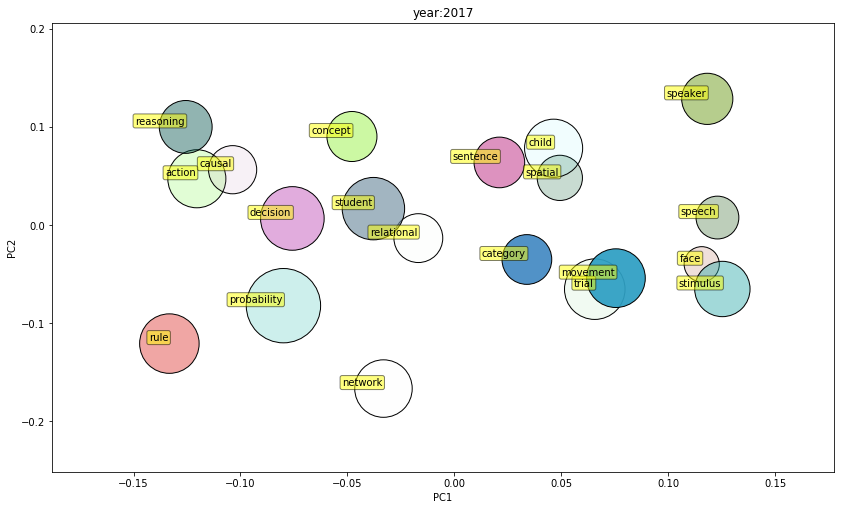

In [97]:
colors = np.random.random((20, 4))
for year in range(18):
    vis_dtm = allvisdtm[year]
    data = vis_dtm[0]['x']
    labels = vis_dtm[0]['topiclabel']
    
    f=plt.figure(figsize=(14, 8))
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(
        vis_dtm[0]['x'], vis_dtm[0]['y'], marker='o', s=vis_dtm[0]['Freq'] * 600, c=colors,edgecolor='k',
        cmap=plt.get_cmap('Spectral'))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim([-0.2,0.2])
    for label, x, y in zip(labels, vis_dtm[0]['x'], vis_dtm[0]['y']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))#,
    #        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.title('year:'+str(2000+year))
    plt.savefig('output/pca/year:'+str(2000+year)+'.png')
    plt.show()
